### Test case LVV-T73: Verify implementation of Deep Detection Coadd

Verify that the DRP pipelines produce a suite of per-band coadded images that are optimized for depth.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.geom as geom
from lsst.pipe.tasks.registerImage import RegisterConfig, RegisterTask

In [2]:
butler = Butler('/repo/embargo', collections="LSSTCam/runs/DRP/20250604_20250814/w_2025_33/DM-52202")

#### Confirm that coadds were made for all sky areas overlapping visits/ccds

For all entries in the `visit_detector_table`, query the Butler to confirm that a `deep_coadd` exists that overlaps the central coordinate of the detector (i.e., that all tracts/patches that should have a coadd indeed do have one).

Note that a small number of images may not have corresponding coadds, as they may be the only image overlapping that sky coordinate. The number of such images should be a tiny fraction of all visits.

In [3]:
ccdvis = butler.get('visit_detector_table')

In [4]:
failed_visits = []

nsamples = 5000
random_indices = np.random.randint(0, len(ccdvis), nsamples)

for vis in ccdvis[random_indices]:
    band = vis['band']
    try:
        query = butler.query_datasets('deep_coadd', band=band, where="patch.region OVERLAPS POINT(:ra, :dec)",
                                      bind={'ra':vis['ra'], 'dec':vis['dec']})
    except:
        failed_visits.append(vis['visitId'])


In [5]:
print(f"Percentage of visits with no coadd: {100.0*len(failed_visits)/nsamples} %")

Percentage of visits with no coadd: 1.96 %


We see that roughly 2% of images do not have a corresponding coadd. This is an expected level of "edge" detectors that do not have multiple images to coadd.

#### Display and inspect images

Select a single `deep_coadd` image in each band. Specify only a patch number and band, and limit the query results to return only one dataset reference.

In [6]:
coadd_refs_dict = {}
bands_list = ['u', 'g', 'r', 'i', 'z', 'y']
for band in bands_list:
    coadd_refs_dict[band] = butler.query_datasets('deep_coadd', band=band,
                                                  patch=32, skymap='lsst_cells_v1', limit=1)

In [7]:
coadd_refs_dict

{'u': [DatasetRef(DatasetType('deep_coadd', {band, skymap, tract, patch}, ExposureF), {band: 'u', skymap: 'lsst_cells_v1', tract: 2703, patch: 32}, run='LSSTCam/runs/DRP/20250604_20250814/w_2025_33/DM-52202/20250818T141547Z', id=c366b9e3-46d3-4877-9eda-220c1451ddcd)],
 'g': [DatasetRef(DatasetType('deep_coadd', {band, skymap, tract, patch}, ExposureF), {band: 'g', skymap: 'lsst_cells_v1', tract: 2233, patch: 32}, run='LSSTCam/runs/DRP/20250604_20250814/w_2025_33/DM-52202/20250818T141547Z', id=ab06631b-bd65-48c4-bbb4-a6556a12718b)],
 'r': [DatasetRef(DatasetType('deep_coadd', {band, skymap, tract, patch}, ExposureF), {band: 'r', skymap: 'lsst_cells_v1', tract: 2233, patch: 32}, run='LSSTCam/runs/DRP/20250604_20250814/w_2025_33/DM-52202/20250818T141547Z', id=4ff2eee1-9c00-4ed9-b130-edb0c22ce5f7)],
 'i': [DatasetRef(DatasetType('deep_coadd', {band, skymap, tract, patch}, ExposureF), {band: 'i', skymap: 'lsst_cells_v1', tract: 2233, patch: 32}, run='LSSTCam/runs/DRP/20250604_20250814/w_202

#### Display the ugrizy images

In [8]:
afwDisplay.setDefaultBackend('matplotlib')

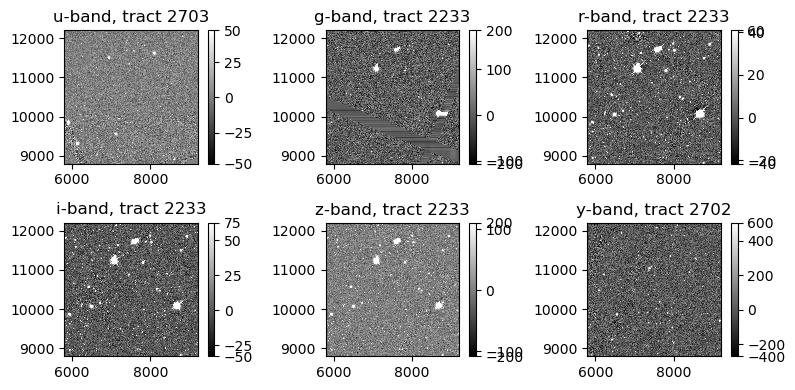

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(8, 4))

for i, band in enumerate(bands_list):
    img = butler.get(coadd_refs_dict[band][0])
    if i<=2:
        fig.sca(axs[0, i])
    else:
        fig.sca(axs[1, i-3])
    display0 = afwDisplay.Display(frame=fig)
    display0.scale('linear', 'zscale')
    display0.mtv(img.image)
    plt.title(f"{band}-band, tract {coadd_refs_dict[band][0].dataId['tract']}")

plt.tight_layout()
plt.show()

#### Extract the list of inputs to a `deep_coadd`

In [10]:
# Extract the i-band image:
inputs = butler.get(coadd_refs_dict['i'][0]).info.getCoaddInputs().ccds.asAstropy()
inputs

id,bbox_min_x,bbox_min_y,bbox_max_x,bbox_max_y,ccd,visit,goodpix,weight,filter
,pix,pix,pix,pix,,,,,
int64,int32,int32,int32,int32,int32,int64,int32,float64,str32
47613894729,0,0,4071,3999,73,2025071700608,1726944,0.0010951262690202025,i_39
47613894731,0,0,4071,3999,75,2025071700608,1744992,0.0010951262690202025,i_39
47613894732,0,0,4071,3999,76,2025071700608,10771017,0.0010951262690202025,i_39
47613894985,0,0,4071,3999,73,2025071700609,1728420,0.0011000554942867768,i_39
47613894987,0,0,4071,3999,75,2025071700609,1748486,0.0011000554942867768,i_39
47613894988,0,0,4071,3999,76,2025071700609,10765380,0.0011000554942867768,i_39
47613895241,0,0,4071,3999,73,2025071700610,346291,0.0011184314334425176,i_39
47613895243,0,0,4071,3999,75,2025071700610,1785776,0.0011184314334425176,i_39


In [11]:
print(f"Number of unique input visits: {len(np.unique(inputs['visit']))}")

Number of unique input visits: 13


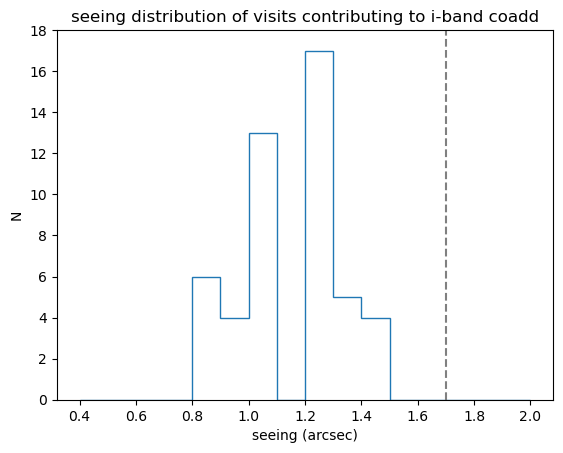

In [12]:
seeing_vals = []

for inp in inputs:
    pick_vis = (ccdvis['visitId'] == inp['visit']) & (ccdvis['detectorId'] == inp['ccd'])
    seeing_vals.append(ccdvis['seeing'][pick_vis].value[0])

plt.hist(seeing_vals, bins=np.arange(0.4, 2.1, 0.1), histtype='step')
plt.vlines(1.7, 0, 18, linestyle='--', color='Gray')
plt.ylim(0, 18)
plt.xlabel('seeing (arcsec)')
plt.ylabel('N')
plt.title('seeing distribution of visits contributing to i-band coadd')
plt.show()

The threshold for inclusion in coadds is PSF FWHM < 1.7 arcsec. This value is highlighted by the dashed line in the figure above; we see that all of the visits meet this selection criterion.

We see that this i-band `deep_coadd` image was created from 49 input CCD images from 13 visits.

#### Compare visit and deep_coadd images

The visit image needs to be registered (or "warped") to the same sky orientation as the deep coadd. We define a function to do this, then display the coadd and visit images side-by-side.

In [13]:
def warp_img(ref_img, img_to_warp, ref_wcs, wcs_to_warp):

    config = RegisterConfig()
    task = RegisterTask(name="register", config=config)
    warpedExp = task.warpExposure(img_to_warp, wcs_to_warp, ref_wcs,
                                  ref_img.getBBox())

    return warpedExp

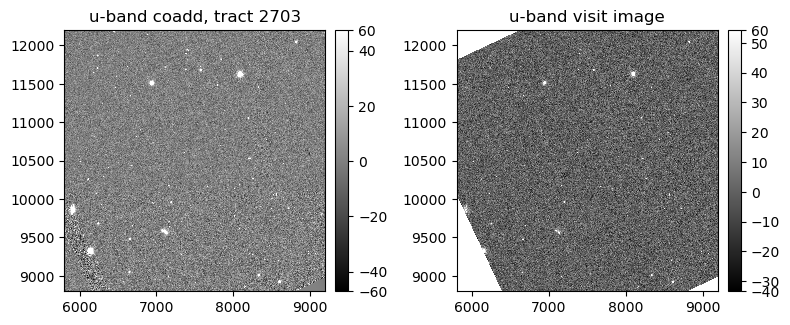

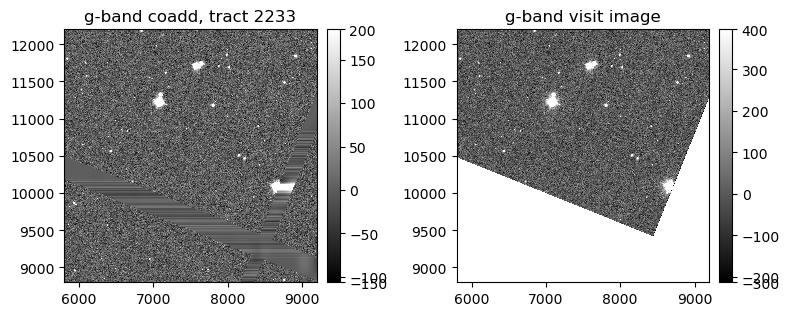

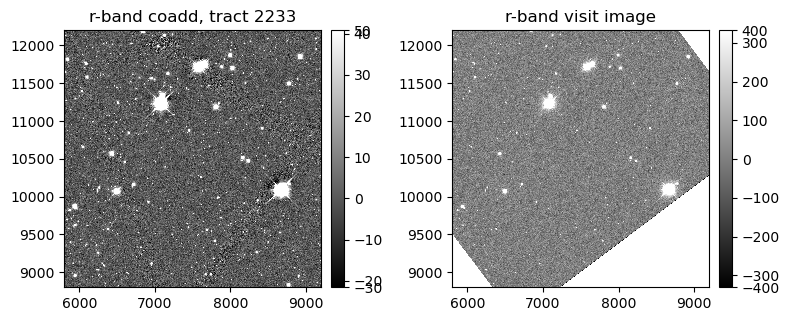

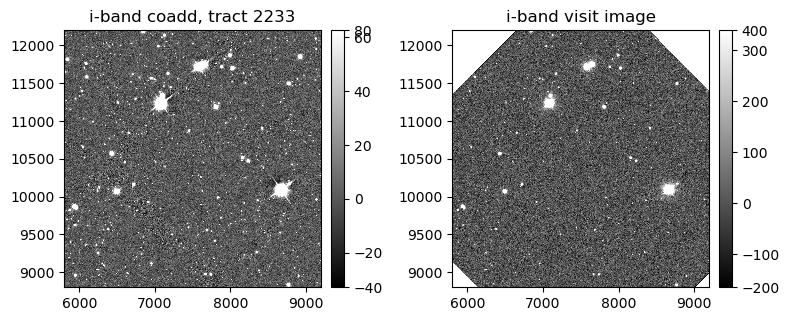

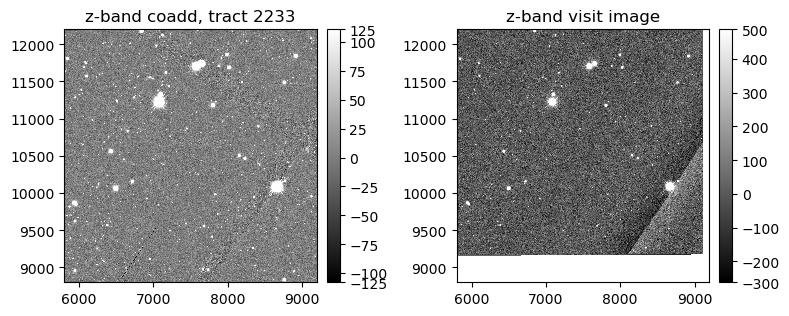

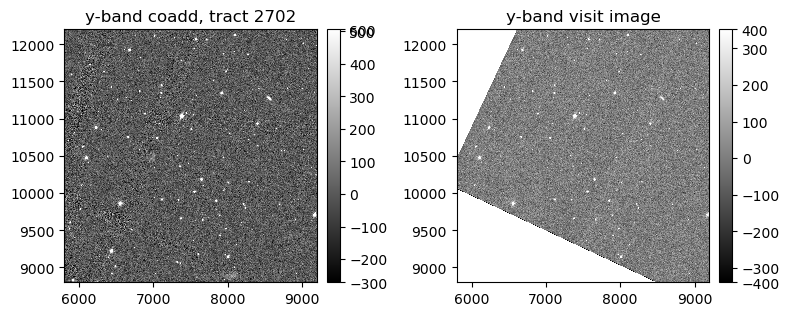

In [14]:
for i, band in enumerate(bands_list):
    img = butler.get(coadd_refs_dict[band][0])
    inputs = img.info.getCoaddInputs().ccds.asAstropy()
    index = np.argmax(inputs['goodpix'])
    visim = butler.get('preliminary_visit_image', visit=inputs['visit'][index], detector=inputs['ccd'][index])
    img_warped = warp_img(img, visim, img.getWcs(), visim.getWcs())

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    fig.sca(axs[0])
    display0 = afwDisplay.Display(frame=fig)
    display0.scale('linear', 'zscale')
    display0.mtv(img.image)
    plt.title(f"{band}-band coadd, tract {coadd_refs_dict[band][0].dataId['tract']}")

    fig.sca(axs[1])
    display1 = afwDisplay.Display(frame=fig)
    display1.scale('linear', 'zscale')
    display1.mtv(img_warped.image)
    plt.title(f"{band}-band visit image")

    plt.tight_layout()
    plt.show()

One can visually see that the `deep_coadd` images are deeper than the single-visit images.

#### Configuration

Examine the configuration that was used for the tasks to select visits and assemble them into a coadd.

In [15]:
cfg = butler.get('selectDeepCoaddVisits_config', dataId=coadd_refs_dict['i'][0].dataId)
cfg

lsst.pipe.tasks.selectImages.BestSeeingSelectVisitsConfig(saveLogOutput=True, nVisitsMax=-1, maxPsfFwhm=1.7, minPsfFwhm=0.0, doConfirmOverlap=True, visitSummaryMinValues={'effTimeZeroPointScale': 0.75}, connections={'skyMap': 'skyMap', 'visitSummaries': 'visit_summary', 'goodVisits': 'deep_coadd_visit_selection', 'coaddName': 'goodSeeing', 'calexpType': ''})

We see that image quality cuts were applied in the selection of coadd inputs. In particular, thresholds were applied to the PSF FWHM ("maxPsfFwhm=1.7") and the scale factor for effective exposure time based on the zero point (effTimeZeroPointScale > 0.75), which is an estimate of the image depth relative to expected depth.

Next we examine the `assembleDeepCoadd` configs, which contain numerous options controlling the coaddition process:

In [16]:
cfg = butler.get('assembleDeepCoadd_config', dataId=coadd_refs_dict['i'][0].dataId)
cfg

lsst.drp.tasks.assemble_coadd.CompareWarpAssembleCoaddConfig(saveLogOutput=True, coaddName='deep', select={'saveLogOutput': True, 'maxEllipResidual': 0.007, 'maxSizeScatter': None, 'maxScaledSizeScatter': 0.019, 'maxPsfTraceRadiusDelta': 0.7, 'maxPsfApFluxDelta': 0.24, 'maxPsfApCorrSigmaScaledDelta': 0.22, 'minNPsfStarPerBand': {'u': 6, 'g': 6, 'r': 6, 'i': 6, 'z': 6, 'y': 6, 'fallback': 6}, 'excludeDetectors': [], 'connections': {'coaddName': 'deep'}}, badMaskPlanes=['NO_DATA', 'BAD', 'SAT', 'SUSPECT'], inputRecorder={'saveEmptyCcds': False, 'saveErrorCcds': False, 'saveVisitGoodPix': True, 'saveCcdWeights': True}, includeCalibVar=False, warpType='direct', subregionSize=[10000, 100], statistic='MEAN', doOnlineForMean=True, sigmaClip=3.0, clipIter=2, calcErrorFromInputVariance=True, doScaleZeroPoint=False, scaleZeroPoint={'zeroPoint': 27.0}, doInterp=True, interpImage={'modelPsf': {'size': None, 'sizeFactor': 3.0, 'minSize': 5, 'maxSize': None, 'defaultFwhm': 3.0, 'addWing': True, 'win

## Results

We have demonstrated that the DM pipelines are producing per-band deep coadd detection images, and examined their properties and associated data products and metadata. The result of this test is a **Pass**.